# Import lib

In [1]:
import pythonradex

# # import necessary modules
from pythonradex import radiative_transfer, helpers, LAMDA_file, atomic_transition
from scipy import constants
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
from tqdm import tqdm
from scipy import constants

from scipy.stats import norm

# libraries to remove unecessary printings coused by radex
import contextlib
import io

import sys

# Initial setup

In [14]:
# ============================
# (1) Set up the "true" simulation
# ============================

# Path to the molecular data file (CH3OH from the LAMDA database)
datafilepath_methanol = r"C:\Users\alios\OneDrive - University College London\Desktop\UCL\Year3\group project\codes\e_ch3oh.dat"

data_methanol = LAMDA_file.read(datafilepath_methanol, read_frequencies=False)

# Geometry and line profile
geometry = "uniform sphere"
line_profile_type = "Gaussian"

# True simulation parameters (using your constants)
N = 1e16 / constants.centi**2  # CH3OH_e column density in m^-2
width_v = 4 * constants.kilo  # line width in m/s (1 km/s * 2)
Tkin = 120  # kinetic temperature in K

observed_spectrum_n_collider = 1e8  # collider density in cm^-3
LTE_collider_densities_h2only = {"H2": observed_spectrum_n_collider / constants.centi**3}  # collider density in m^-3
T_dust = 0
tau_dust = 0
ext_background = helpers.generate_CMB_background(z=0)

# Create the "true" cloud object using your variable names
cloud_metahnol = radiative_transfer.Cloud(
    datafilepath=datafilepath_methanol,
    geometry=geometry,
    line_profile_type=line_profile_type,
    width_v=width_v,
)
cloud_metahnol.update_parameters(
    N=N,
    Tkin=Tkin,
    collider_densities=LTE_collider_densities_h2only,
    ext_background=ext_background,
    T_dust=T_dust,
    tau_dust=tau_dust,
)
with contextlib.redirect_stdout(io.StringIO()):
    cloud_metahnol.solve_radiative_transfer()


# Define a helper function to extract values from the cloud and data file
def extract_values(cloud_name, data_of_molecule):
    # Excitation temperature and optical depth
    Tex = cloud_name.Tex
    tau = cloud_name.tau_nu0_individual_transitions
    # Einstein coefficients and transition frequencies
    Aul = cloud_name.emitting_molecule.A21
    Bul = cloud_name.emitting_molecule.B21
    nu0_array = cloud_name.emitting_molecule.nu0
    # Extract level energies (convert from Joule to Kelvin)
    levels = data_of_molecule["levels"]
    Eu = np.array([level.E for level in levels]) / constants.k
    Eu = Eu[1:]  # remove first component (nan)
    g_weigth = np.array([level.g for level in levels])[1:]

    return Tex, tau, Aul, Bul, nu0_array, Eu, g_weigth


TexCH3OH, tauCH3OH, AulCH3OH, BulCH3OH, nu0_arrayCH3OH, EuCH3OH, gCH3OH = extract_values(cloud_metahnol, data_methanol)

# For simplicity, take only the first 10 transitions
firstN_transitions = 30
TexCH3OH = TexCH3OH[:firstN_transitions]
tauCH3OH = tauCH3OH[:firstN_transitions]
AulCH3OH = AulCH3OH[:firstN_transitions]
BulCH3OH = BulCH3OH[:firstN_transitions]
nu0_arrayCH3OH = nu0_arrayCH3OH[:firstN_transitions]
EuCH3OH = EuCH3OH[:firstN_transitions]
gCH3OH = gCH3OH[:firstN_transitions]

# Compute the fluxes from the cloud
distance_observer = 100 * constants.parsec  # observer distance in m
source_radius = 10 * constants.au  # source radius in m
source_solid_angle = source_radius**2 * np.pi / distance_observer**2

flux_methanol = cloud_metahnol.fluxes_of_individual_transitions(transitions=list(range(firstN_transitions)), solid_angle=source_solid_angle)
# Define an arbitrary fwhm in frequency (using the first transition as reference)
fwhm_frequancy = nu0_arrayCH3OH[0] * 0.2

# Choose a specific transition (e.g. transition 2) for the MCMC fit
choose_transition = 2


# Define a Gaussian function (as in your code)
def gaussian(x, amp, cen, fwhm):
    """Gaussian function with amplitude, center, and FWHM as parameters

    Parameters
    ----------
    x : array_like
        The frequency axis
    amp : float
        Amplitude of the Gaussian
    cen : float
        Center of the Gaussian
    fwhm : float
        Full Width at Half Maximum of the Gaussian

    Returns
    -------
    array_like
        The Gaussian function evaluated at the frequency axis x
    """
    sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))
    return amp * np.exp(-((x - cen) ** 2) / (2 * sigma**2))


c:\Users\alios\AppData\Local\Programs\Python\Python312\Lib\site-packages\pythonradex\radiative_transfer.py:110: UserWarning: some lines are overlapping, but treatement of overlapping lines not activated
  warnings.warn('some lines are overlapping, but treatement of'


# Plot spectum

In [3]:
def model_spectrum(x, params):
    """
    Create spectrum, sum of Gaussians.

    Parameters:
        x: array-like, the independent variable (e.g., wavelength)
        params: list or array of parameters. For n Gaussians, params should be of length 3*n,
                where each Gaussian has [amp, cen, fwhm] in order.

    Returns:
        The sum of Gaussians evaluated at x.
    """
    n_gauss = len(params) // 3
    total = np.zeros_like(x)
    for i in range(n_gauss):
        amp = params[3 * i]
        cen = params[3 * i + 1]
        fwhm = params[3 * i + 2]
        total += gaussian(x, amp, cen, fwhm)
    return total

In [4]:
realistic_fwhm = nu0_arrayCH3OH * (width_v / constants.c)

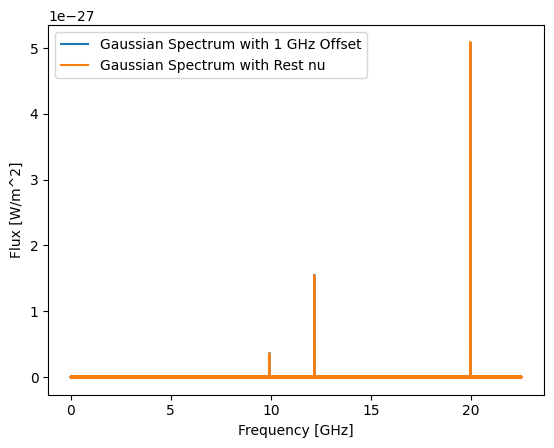

In [ ]:
# number of transitions to plot in spectrum
n_trans_spectrum = 10

# generate frequency space
x = np.linspace(0, nu0_arrayCH3OH[n_trans_spectrum] * 1.01, int(1e5))

# compute the offset using V_LSR
# V_LSR = 0.0001 * constants.c
V_LSR = 0.3

nu0_arrayCH3OH_observed = nu0_arrayCH3OH * (1 - (V_LSR * 100) / constants.c)

params_observed = []
params_rest = []
for i in range(n_trans_spectrum):
    params_observed.extend([flux_methanol[i], nu0_arrayCH3OH_observed[i], realistic_fwhm[i]])
    params_rest.extend([flux_methanol[i], nu0_arrayCH3OH[i], realistic_fwhm[i]])

# Generate the spectra
no_noise_spectrum_observed = model_spectrum(x, params_observed)
no_noise_spectrum_rest = model_spectrum(x, params_rest)

noise_std_observed = 0.0005 * np.max(no_noise_spectrum_observed)
noise_std_rest = 0.0005 * np.max(no_noise_spectrum_rest)

observed_spectrum = no_noise_spectrum_observed + np.random.normal(0, noise_std_observed, len(x))
spectrum_rest = no_noise_spectrum_rest + np.random.normal(0, noise_std_rest, len(x))

# Plot the spectra
fig, ax = plt.subplots()
plt.plot(x / constants.giga, observed_spectrum, label="Gaussian Spectrum with Offset")
plt.plot(x / constants.giga, spectrum_rest, label="Gaussian Spectrum with Rest nu")
plt.xlabel("Frequency [GHz]")
plt.ylabel(r"Flux [W/m^2]")
plt.legend()
plt.show()

In [6]:
V_LSR_cpersentage = (V_LSR) / constants.c
print(f"V_LSR in persentage of speed of light: {V_LSR_cpersentage}%")

V_LSR in persentage of speed of light: 1.0006922855944562e-09%


# Define the MCMC model functions

In [7]:
cloud_candidate = radiative_transfer.Cloud(
    datafilepath=datafilepath_methanol,
    geometry=geometry,
    line_profile_type=line_profile_type,
    width_v=width_v,
)


def simulate_spectrum_from_params(Tkin_candidate, log_n_H2_candidate, V_LSR, width_v_candidate, debug=False):
    """Simulate a spectrum from multiple transitions for a given set of parameters

    Parameters
    ----------
    Tkin_candidate : float
        Kinetic temperature of the candidate cloud in K
    log_n_H2_candidate : float
        Logarithm of the H2 density of the candidate cloud in cm^-3
    V_LSR : float
        The velocity of the candidate cloud in km/s
    debug : bool, optional
        Print debug information, by default False"""

    # Convert log-density to linear density (matching your units)
    n_H2_candidate = 10 ** (log_n_H2_candidate) / constants.centi**3
    # Create a new cloud with the candidate width_v

    # check the parameter ranges
    assert 20 < Tkin_candidate < 500, f"Tkin_candidate out of range: {Tkin_candidate}"
    assert 2 < log_n_H2_candidate < 10, f"log_n_H2_candidate out of range: {log_n_H2_candidate}"
    # assert 0 < nu < 2000, f"nu_offset out of range: {nu}"

    cloud_candidate.update_parameters(
        N=N,
        Tkin=Tkin_candidate,
        collider_densities={"H2": n_H2_candidate},
        ext_background=ext_background,
        T_dust=T_dust,
        tau_dust=tau_dust,
    )
    # Suppress the print statements in solve_radiative_transfer
    with contextlib.redirect_stdout(io.StringIO()):
        cloud_candidate.solve_radiative_transfer()
    # Get the flux for the chosen transition
    flux_candidate = cloud_candidate.fluxes_of_individual_transitions(transitions=list(range(firstN_transitions)), solid_angle=source_solid_angle)

    # move the rest nu by V_LSR
    nu = nu0_arrayCH3OH * (1 - (V_LSR * 100) / constants.c)

    # width in freqancy space
    fwhm_candidate = nu0_arrayCH3OH * (width_v_candidate / constants.c)
    params = []
    for i in range(n_trans_spectrum):
        params.extend([flux_candidate[i], nu[i], fwhm_candidate[i]])

    # print("flux of spectrum ", flux_candidate)
    if debug:
        print("params ", params)
        print("nu ", nu)

    # Build the model line using the same Gaussian profile (center and fwhm_frequancy fixed)
    model_all_spectrum = model_spectrum(x, params)
    return model_all_spectrum

c:\Users\alios\AppData\Local\Programs\Python\Python312\Lib\site-packages\pythonradex\radiative_transfer.py:110: UserWarning: some lines are overlapping, but treatement of overlapping lines not activated
  warnings.warn('some lines are overlapping, but treatement of'


c:\Users\alios\AppData\Local\Programs\Python\Python312\Lib\site-packages\pythonradex\radiative_transfer.py:333: UserWarning: negative optical depth!
  warnings.warn('negative optical depth!')


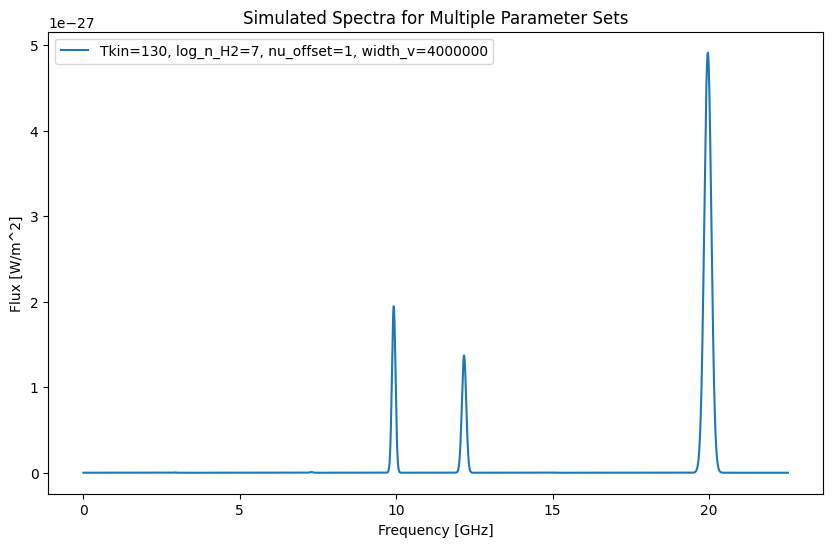

In [13]:
# Define multiple sets of parameters
# parameter_sets = [(130, 7, 1), (130, 7, 300), (130, 7, 50)]
parameter_sets = [(130, 7, 1, 4000000)]
# parameter_sets = [(130, 7, 1)]

# Plot all spectra
plt.figure(figsize=(10, 6))
for Tkin_candidate, log_n_H2_candidate, nu_offsets, width_v_test in parameter_sets:
    spec = simulate_spectrum_from_params(Tkin_candidate, log_n_H2_candidate, nu_offsets, width_v_test)
    plt.plot(x / constants.giga, spec, label=f"Tkin={Tkin_candidate}, log_n_H2={log_n_H2_candidate}, nu_offset={nu_offsets}, width_v={width_v_test}")

plt.xlabel("Frequency [GHz]")
plt.ylabel(r"Flux [W/m^2]")
plt.legend()
plt.title("Simulated Spectra for Multiple Parameter Sets")
plt.show()

In [9]:
# sys.exit("Stopping execution here")

# Define log_likelihood, log_prior and log_probability


Running MCMC... (this may take a while)


MCMC Sampling: 100%|██████████| 200/200 [02:51<00:00,  1.17step/s]


Mean parameter estimates [Tkin, log10(n_H2), V_LSV [km/s], width_v [m/s]]:
[1.19981272e+02 7.97313065e+00 5.40674794e-01 3.97961681e+03]


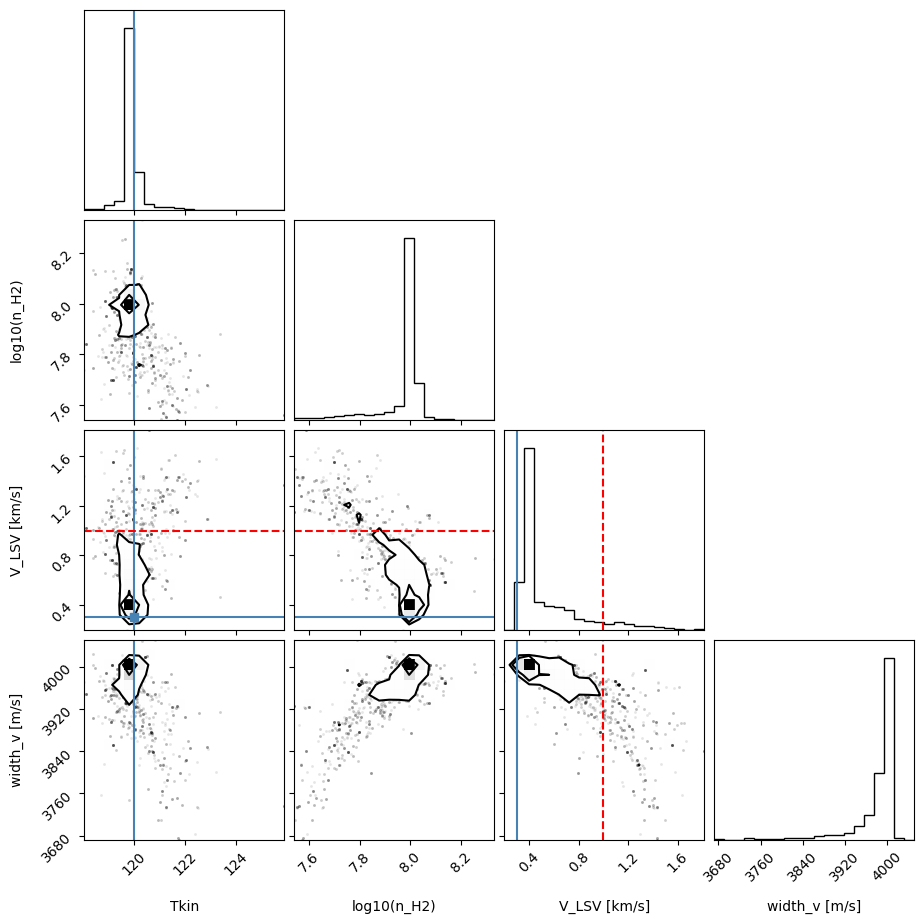

c:\Users\alios\AppData\Local\Programs\Python\Python312\Lib\site-packages\pythonradex\radiative_transfer.py:333: UserWarning: negative optical depth!
  warnings.warn('negative optical depth!')


Best fit parameters: Tkin = 119.94314375227148, log10(n_H2) = 8.000614208157536, V_LSV [km/s] = 0.406569442987577, width_v [m/s] = 3996.0002783188165


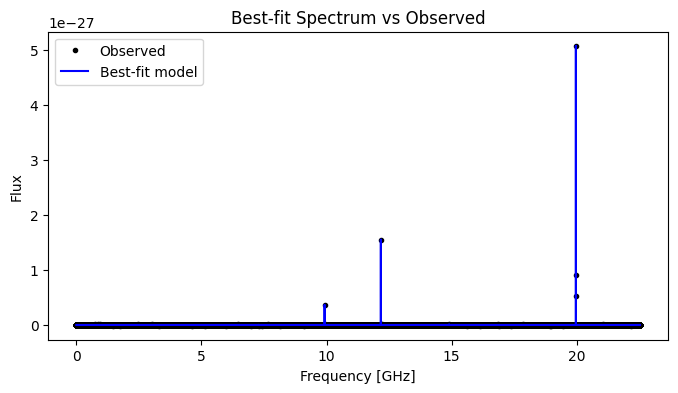

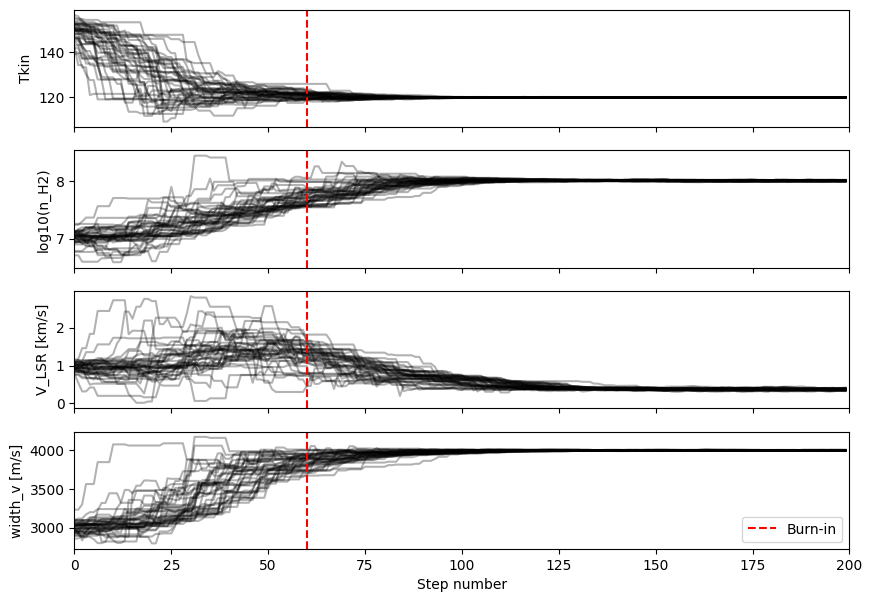

In [10]:
def log_likelihood_radex(theta, x, y, yerr):
    Tkin_candidate, log_n_H2_candidate, vlsr_candidate, width_v_candidate = theta
    # print(f"Evaluating log_likelihood with theta: {theta}")
    model = simulate_spectrum_from_params(Tkin_candidate, log_n_H2_candidate, vlsr_candidate, width_v_candidate)
    log_likelihood_value = -0.5 * np.sum(((y - model) / yerr) ** 2)
    # print(f"log_likelihood: {log_likelihood_value}")
    return log_likelihood_value


def log_prior(theta):
    Tkin_candidate, log_n_H2_candidate, vlsr_candidate, width_v_candidate = theta
    # print(f"Checking log_prior with Tkin_candidate={Tkin_candidate}, log_n_H2_candidate={log_n_H2_candidate}, vlsr_candidate={vlsr_candidate}")

    if 20 < Tkin_candidate < 300 and 5 < log_n_H2_candidate < 9 and 0 < vlsr_candidate < 3 and 500 < width_v_candidate < 5000:
        return 0.0
    return -np.inf


# Combine to form the full log-probability function
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    # print(f"theta: {theta}")
    return lp + log_likelihood_radex(theta, x, y, yerr)


# reset sampler to zero
samples = []
pos = []

# Initial guess for the parameters [Tkin, width_v, log10(n_H2)]
initial_tkin = 150
initial_log_n_H2 = 7
initial_offset = 1
initial_width_v = 3000

initial = np.array([initial_tkin, initial_log_n_H2, initial_offset, initial_width_v])

ndim = len(initial)
nwalkers = 40
# Define noise levels for each parameter
noise_levels = np.array([5, 0.1, 0.1, 50])  # Adjust these values as needed

# Initialize walkers in a small Gaussian ball around the initial guess
pos = initial + noise_levels * np.random.randn(nwalkers, ndim)

print("Running MCMC... (this may take a while)")
nsteps = 200
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, observed_spectrum, noise_std_observed))
with tqdm(total=nsteps, desc="MCMC Sampling", unit="step") as pbar:
    for result in sampler.sample(pos, iterations=nsteps, progress=False):  # Disable emcee's built-in progress bar
        pbar.update(1)  # Update tqdm progress bar

# Discard burn-in and flatten the chain
burnin = int(0.3 * nsteps)
samples = sampler.get_chain(discard=burnin, flat=True)
print("Mean parameter estimates [Tkin, log10(n_H2), V_LSV [km/s], width_v [m/s]]:")
print(np.mean(samples, axis=0))

# Create a corner plot for the posterior samples
fig_corner = corner.corner(
    samples, labels=["Tkin", "log10(n_H2)", "V_LSV [km/s]", "width_v [m/s]"], truths=[Tkin, observed_spectrum_n_collider, V_LSR, width_v]
)

# Add initial guess
corner.overplot_lines(fig_corner, initial, color="red", linestyle="--")
corner.overplot_points(fig_corner, initial[None], marker="o", color="red")
plt.show()

# Plot the best-fit model vs the observed spectrum
Tkin_best, log_n_H2_best, nu_offset_best, width_v_best = np.median(samples, axis=0)
model_best = simulate_spectrum_from_params(Tkin_best, log_n_H2_best, nu_offset_best, width_v_best)

# print the best fit parameters
print(f"Best fit parameters: Tkin = {Tkin_best}, log10(n_H2) = {log_n_H2_best}, V_LSV [km/s] = {nu_offset_best}, width_v [m/s] = {width_v_best}")

plt.figure(figsize=(8, 4))
plt.plot(x / constants.giga, observed_spectrum, "k.", label="Observed")
plt.plot(x / constants.giga, model_best, "b-", label="Best-fit model")
plt.xlabel("Frequency [GHz]")
plt.ylabel("Flux")
plt.legend()
plt.title("Best-fit Spectrum vs Observed")
plt.show()

# Plot trace plots for each parameter
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["Tkin", "log10(n_H2)", "V_LSR [km/s]", "width_v [m/s]"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.axvline(burnin, color="r", linestyle="--", label="Burn-in")
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
axes[-1].set_xlabel("Step number")
plt.legend()
plt.show()

In [15]:
print("Tkin observed spectrum = ", Tkin)
print("log10(n_H2) observed spectrum = ", "{:.1e}".format(observed_spectrum_n_collider))
print("V_LSR observed spectrum = ", V_LSR)
print("width_v observed spectrum = ", width_v)

Tkin observed spectrum =  120
log10(n_H2) observed spectrum =  1.0e+08
V_LSR observed spectrum =  0.3
width_v observed spectrum =  4000.0
